# Waveform Triggering

## A. Square Waves
First, an otherwise ideal square wave is given a simulated DC offset and a time shift (delay)  for simulating inputs from the Topside Control ADC System. Values of voltage are in a range of integers from $[0, 65565]$ with a discrete time domain of $N=8192$. Once the construction of simlated waves is robust, this can be applied to a model of multiple channels and include noise to make the results more realistic before implementing this logic on real data! 

In [3]:
# First some imports for necessary processing libraries.
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from numpy import fft as fft

In [4]:
# TODO: Make this into a function for repetitive use.
N = 8192  # number of samples
T = 1 # Sampling period (seconds)
F_s = 8192  # [Samples/second]
tau = np.float(1./F_s)
TIME_OFFSET = N/2  # time offset provided for simulation
AMP = 2000  # amplitude (in ADC values)
NOISE_LVL = AMP / 20  # Naive way to set noise on the signal (not true SNR)
DC_OFFSET = 4000  # DC offset in ADC values
F_tx = 4.00  # Fundamental frequency of the waveform (Hz)
t = np.linspace(0, N-1, N, endpoint=False)
noise = NOISE_LVL * np.random.normal(0, 1, t.shape)
pure_sig = AMP * signal.square(2 * np.pi * F_tx * t - TIME_OFFSET) + NOISE_LVL * np.sin(np.pi* 60 *t) + DC_OFFSET
sig = pure_sig + noise
# print(len(t))

The waveform also has an average and a peak-to-peak value. We need the average to rezero the waveform such that rising and falling edges cross zero (see 1a below).

In [5]:
offset_average = np.average(sig)
print(f"Waveform Average Value = {offset_average}")

Waveform Average Value = 4001.306468980579


In [6]:
# Plotting the waveform as a sanity check:
def plot_waveform(t, sig, dc_offset, amplitude, domain_size, ypad=1000):
    plt.plot(t, sig)
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.axis([-100, domain_size-1, -dc_offset - amplitude + ypad, dc_offset + amplitude + ypad])
    plt.grid(True)
    plt.show()

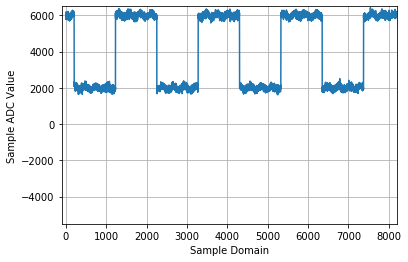

In [7]:
plot_waveform(t, sig, DC_OFFSET, AMP, N, ypad=500)

### 1. Condition Input Waveform

#### a. Remove DC Offset from Average Value

In [8]:
def remove_dc_offset(sig):
    offset_average = np.average(sig)
    # test print
    print(f"Waveform Average Value = {offset_average}")
    return sig - offset_average

Waveform Average Value = 4001.306468980579


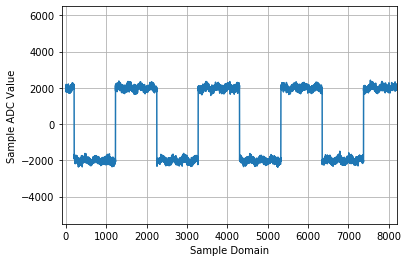

DC values of 4001.306468980579 subtracted from AC waveform!


In [9]:
zeroed_sig = remove_dc_offset(sig)
plot_waveform(t, zeroed_sig, DC_OFFSET, AMP, N, ypad=500)
print(f"DC values of {offset_average} subtracted from AC waveform!")

#### b. Lowpass Filter of zeroed waveform:
Normally in audio synthesis and processing, a 2-pole or 4-pole low pass filter is used to remove high frequency noise from a signal. Here, a 4th order Butterworth-type digital filter is applied to the signal, and the plots of the frequency response and output waveform are provided side-by-side.

In [10]:
def butterworth_digital_lpf(sig, order, f_cut, f_sample):
    """
    .. function:: butterworth_analog_lpf
    .. description::
    :param sig:
    :param order:
    :param f_cut:
    :return w:
    :return h:
    :return filt_sig:
    """
    # Compute the numerator and denominator polynomials of the IIR filter.
    b, a = signal.butter(order, f_cut, 'lp', fs=f_sample, analog=False)
    # Compute the frequency response of an analog filter.
    w, h = signal.freqs(b, a)
    # Define second-order sections representation of the IIR filter.
    sos = signal.butter(order, f_cut, 'lp', fs=f_sample, analog=False, output='sos')
    # Apply the filter to our signal.
    filt_sig = signal.sosfilt(sos, sig)
    return w, h, filt_sig

In [11]:
def plot_wave_freqresp_filter(t, s, filt_s, w, h, order, f_c, dc_offset, amplitude, ypad):
    """
    .. function:: plot_wave_freqresp_filter
    .. description::
    :param t:
    :param s:
    :param filt_s:
    :param w:
    :param h:
    :param order:
    :param f_c:
    :param dc_offset:
    :param amplitude:
    :param ypad:
    :return NONE:
    """
    plt.figure(figsize=(17, 5))
    
    # Raw Waveform
    plt.subplot(131)
    plt.plot(t, s)
    plt.title('Raw Waveform')
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.axis([0, N, -dc_offset - amplitude + ypad, dc_offset + amplitude + ypad])
    plt.grid(True)
    
    # Filtered Waveform
    plt.subplot(132)
    plt.plot(t, filt_s)
    plt.title('Filtered Waveform Copy')
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.axis([0, N, -dc_offset - amplitude + ypad, dc_offset + amplitude + ypad])
    plt.grid(True)
    
    # Butterworth Filter BODE plot (Right Subplot)
    plt.subplot(133)
    plt.semilogx(w, 20*np.log10(abs(h)))
    plt.title(f'{ORDER}-Order \n Butterworth Filter \n Frequency Response')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(f_c, color='green') # cutoff frequency
    
    plt.tight_layout()
    plt.show()

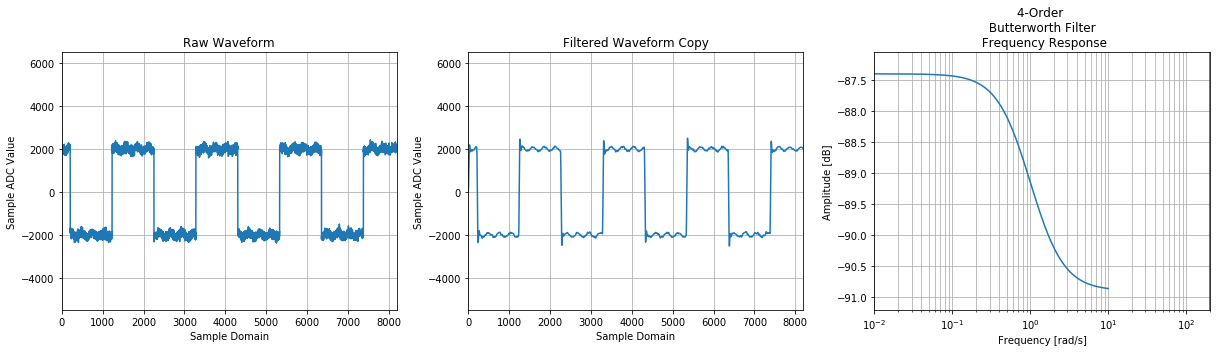

In [12]:
# Define filter parameters
ORDER = 4
F_cut = 200

# Apply filter to obtain angular frequency (w), response (h), and the filtered waveform
ang_freq, resp, filt_zeroed_sig = butterworth_digital_lpf(zeroed_sig, ORDER, F_cut, N)

# and plot results:
plot_wave_freqresp_filter(t, zeroed_sig, filt_zeroed_sig, ang_freq, resp, ORDER,
                          F_cut, DC_OFFSET, AMP, ypad=500)

### 2. Set FFT Window from Triggering Logic

#### a. Rising Edge Trigger for $t_0$ on Filtered Waveform:
The first, naive approach here is to apply a numerical gradient approximation algorithm to segments of the filtered waveform surrounding zero-crossing points. The gradient is used to obtain the indices where $s_j = 0$ and the maximum $\frac{\partial s_j}{\partial n_j} \geq \epsilon$ for waveform array index $j$ and critical slope parameter $\epsilon$. 

Turns out it's even simpler than this if we use a crude finite difference method and assume that certin properties are only met at the positive and negative zero crossings for a properly conditioned waveform... 

The gradient amplitude maximum value is: 237.2712237811643


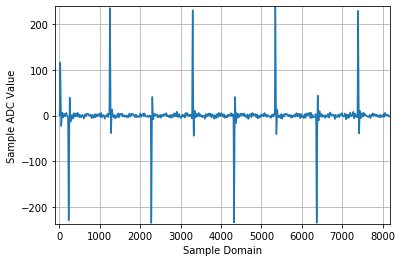

In [13]:
# TODO: Make this into a function
# Calciulate the one dimensional gradient (derivative) along the time series to find trigger 
# points. Positive triggers will correspond with maximum positive values, negative triggers to 
# maximum negative values. 
filt_sig_gradient = np.gradient(filt_zeroed_sig)
gradient_max = np.nanmax(filt_sig_gradient)
print(f"The gradient amplitude maximum value is: {gradient_max}")
plot_waveform(t, filt_sig_gradient, gradient_max, 0, N, ypad=1)

In [14]:
# use a generator to obtain the positive gradient zero-crossing occurrences in the array `filt_zeroed_sig`
# At the moment this is quite crude, but should work... this only works with the DC offset at 0!

positive_trigger_indices = (j for j in range(N - 1) if 
                           ((filt_sig_gradient[j] >= (2/3) * gradient_max) and
                            filt_zeroed_sig[j - 1] < filt_zeroed_sig[j]))
rising_first_trigger = next(positive_trigger_indices)
print(rising_first_trigger)

1244


#### b. Falling Edge Trigger for $t_f$ on Filtered Waveform:

In [15]:
negative_trigger_indices = (j for j in range(N-1, 0, -1)  if 
                            ((filt_sig_gradient[j] <= (2/3) * -gradient_max) and
                             filt_zeroed_sig[j + 1] < filt_zeroed_sig[j]))
falling_last_trigger = next(negative_trigger_indices)
print(falling_last_trigger)

6377


#### c. Construct a tuple $(t_0, t_f)$ of Window boundary indices:

In [16]:
# Make a function of this
window_bounds = (rising_first_trigger, falling_last_trigger)
Nw = np.abs(window_bounds[0] - window_bounds[1])
if Nw % 2 != 0:
    t_0 = window_bounds[0]
    t_f = window_bounds[1] - 1
    window_bounds = (t_0, t_f)
    Nw = np.abs(window_bounds[0] - window_bounds[1])
    print("Window altered for even number of samples...")
    
print(f"(t_0, t_f) = {window_bounds} with sample size {Nw}")

Window altered for even number of samples...
(t_0, t_f) = (1244, 6376) with sample size 5132


### 3. Apply Window to Unfiltered Waveform

#### a. Shift waveform such that $t_0$ to index 0 of unfiltered waveform.

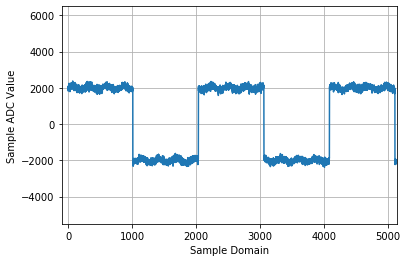

In [17]:
# Make a function
windowed_sig = zeroed_sig[window_bounds[0]:window_bounds[1]]
windowed_t = np.linspace(0, Nw-1, Nw, endpoint=False)
plot_waveform(windowed_t, windowed_sig, DC_OFFSET, AMP, Nw, ypad=500)


### 4.  FFT Original Waveform and Windowed Waveform for Comparison

#### a. FFT original waveform.

In [18]:
# TODO: Make this into a function
raw_fft = fft.fft(zeroed_sig) 
filt_fft = fft.fft(filt_zeroed_sig)
k_domain = fft.fftfreq(N, d = 1/F_s)
print(raw_fft)

[ 2.68300937e-10   +0.j          1.05422040e+04+4698.93097446j
  2.16007842e+03+2481.40259776j ... -9.60685380e+03-6828.26147341j
  2.16007842e+03-2481.40259776j  1.05422040e+04-4698.93097446j]


But first, to make life a little easier... 

In [19]:
def plot_frequency_and_waveform(t, s_t, filt_s_t, k, s_k, filt_s_k, dc_offset,
                                amplitude, N, ypad):
    """
    """
    s_k_intensity = np.nanmax(s_k)   # Arbitrary spectral intensity 
    k_size = k.shape[0] # Number of frequencies in K-domain.
    
    plt.figure(figsize=(15, 12))
    
    # Raw Waveform
    plt.subplot(221)
    plt.plot(t, s_t)
    plt.title('Raw Waveform')
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.axis([0, N, -dc_offset - amplitude + ypad, dc_offset + amplitude + ypad])
    plt.grid(True)
    
    # Filtered Waveform
    plt.subplot(223)
    plt.plot(t, filt_s_t)
    plt.title('Filtered Waveform')
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.axis([0, N, -dc_offset - amplitude + ypad, dc_offset + amplitude + ypad])
    plt.grid(True)
    
    # Raw Fourier Transform
    plt.subplot(222)
    plt.semilogy(k, s_k)
    plt.title('Raw Waveform Fourier Transform')
    plt.xlabel('Frequency $\omega$ Domain [rad/s]')
    plt.ylabel('Spectral Intensity')
    plt.axis([-200, 200, 1, s_k_intensity])
    plt.grid(which='both', axis='both') 
    
    # Filtered Fourier Transform
    plt.subplot(224)
    plt.semilogy(k, filt_s_k)
    plt.title('Filtered Waveform Fourier Transform')
    plt.xlabel('Frequency $\omega$ Domain [rad/s]')
    plt.ylabel('Spectral Intensity')
    # Set the viewing window to -200 to 200 Hz
    plt.axis([-200, 200, 1, s_k_intensity])
    plt.grid(which='both', axis='both')
    
    plt.tight_layout()
    plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:923: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


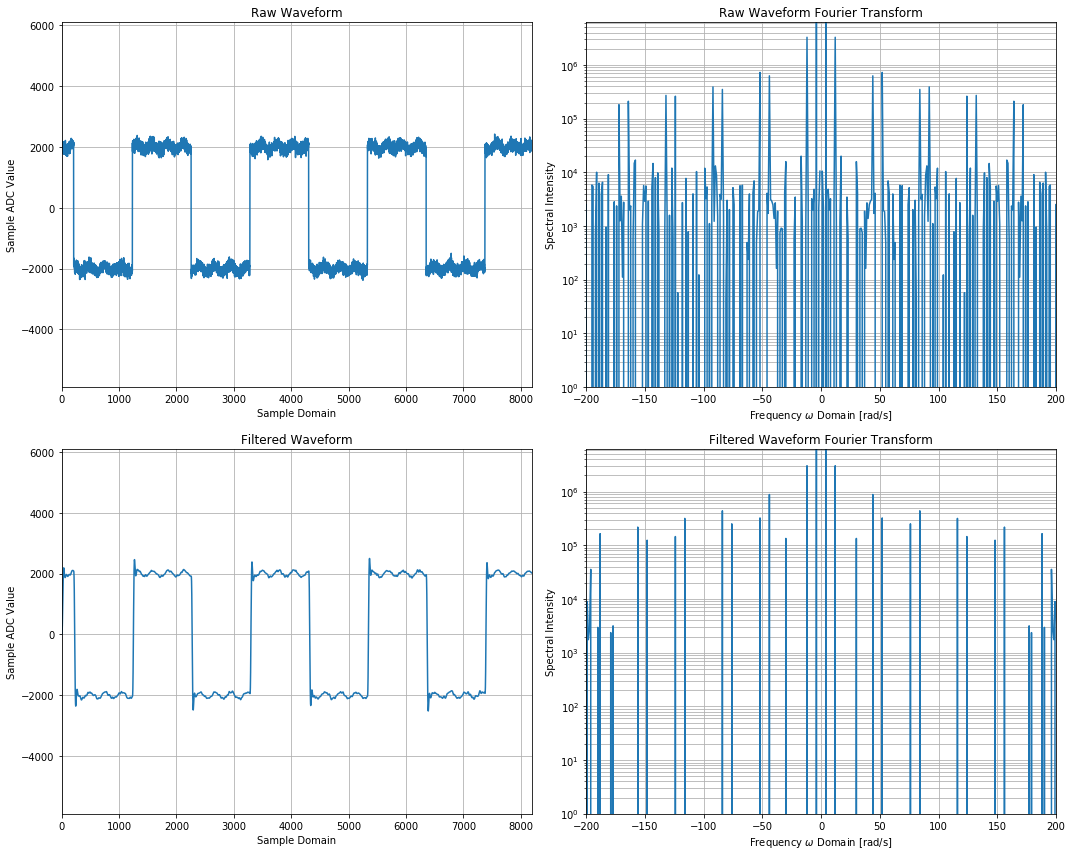

In [20]:
 plot_frequency_and_waveform(t, zeroed_sig, filt_zeroed_sig, k_domain, raw_fft,
                             filt_fft, DC_OFFSET, AMP, N, ypad=100)

The plots above show the FFT for the raw and filtered waveforms without triggering. Next, we apply the same process to the trigger-windowed waveform. The end goal is to show the theoretical reduction in artifacts due to windowing the function.  This is still likely to have some artifacts due to the abrupt cutoff of the window, however a more advanced technique like a Hamming or Gabor-type window might be more appropriate for smoothly truncating the boundaries and providing zero-pads.

It is apparent, however, that filtering will remove some of the higher frequency garbage components.  

Note that the sampling rate is identical, however there are fewer full-period waveforms. The `fftfreq` needs to also be recalculated to account for the reduction in the spatial/time domain. 

[ 1971776.64270433     +0.j          2299290.96139319 +54366.0702399j
  4908424.10155531+217735.41535312j ... -3470056.90767165+233333.72116734j
  4908424.10155531-217735.41535312j  2299290.96139319 -54366.0702399j ]


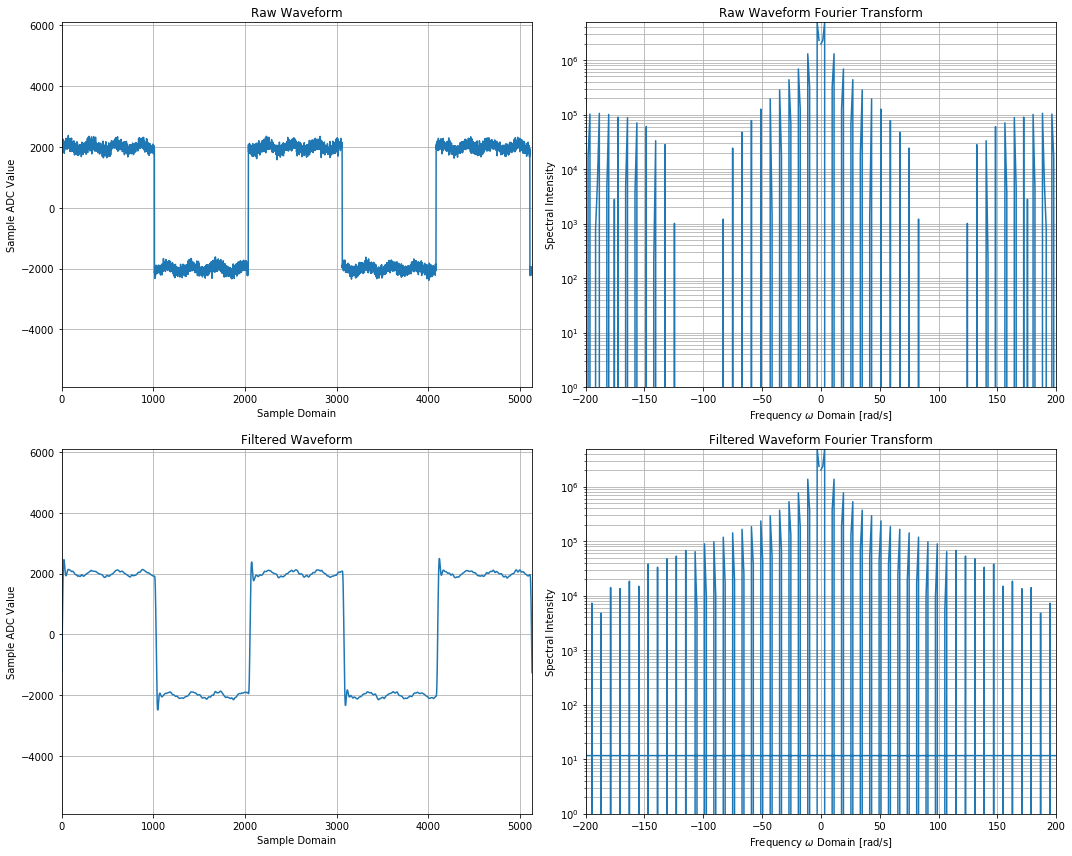

In [21]:
# TODO: Make this into a function
windowed_sig = zeroed_sig[window_bounds[0]:window_bounds[1]]
filt_windowed_sig = filt_zeroed_sig[window_bounds[0]:window_bounds[1]]
windowed_t = np.linspace(0, Nw-1, Nw, endpoint=False)

windowed_raw_fft = fft.fft(windowed_sig) 
windowed_filt_fft = fft.fft(filt_windowed_sig)
k_windowed = fft.fftfreq(Nw, d = 1/F_s)
# print(k_domain.shape[0])
print(windowed_raw_fft)
    
plot_frequency_and_waveform(windowed_t, windowed_sig, filt_windowed_sig, k_windowed, 
                            windowed_raw_fft, windowed_filt_fft, DC_OFFSET, AMP, Nw, ypad=100)

Now the phases and "apparent impedence" values are calculated from both the raw and windowed versions of the waveform. 

In [22]:
# Function for plotting and scaling the phases:
def plot_phase_spectrum(k, k_win, raw_phi, win_phi, filt_phi, win_filt_phi):
    """
    .. function::
    .. description::
    :param k:
    :param k_win:
    :param raw_phi:
    :param win_phi:
    :param filt_phi:
    :param win_filt_phi:
    :return NONE:
    """
    phi_k_intensity = np.nanmax(raw_phi)   # Arbitrary spectral intensity 
    k_size = k.shape[0] # Number of frequencies in K-domain.
    k_win_size = k_win.shape[0]
    
    plt.figure(figsize=(15, 12))
    
    # Raw Waveform
    plt.subplot(221)
    plt.plot(k, raw_phi)
    plt.title('Raw Waveform Phase')
    plt.xlabel('Frequency $\omega$ Domain [rad/s]')
    plt.ylabel('Phase Angle [Radians]')
    plt.axis([-200, 200, -phi_k_intensity, phi_k_intensity])
    plt.grid(True)
    
    # Filtered Waveform
    plt.subplot(222)
    plt.plot(k, filt_phi)
    plt.title('Filtered Waveform Phase')
    plt.xlabel('Frequency $\omega$ Domain [rad/s]')
    plt.ylabel('Phase Angle [Radians]')
    plt.axis([-200, 200, -phi_k_intensity, phi_k_intensity])
    plt.grid(True)
    
    
    # Raw Fourier Transform
    plt.subplot(223)
    plt.plot(k_win, win_phi)
    plt.title('Raw Waveform Phase with Triggering')
    plt.xlabel('Frequency $\omega$ Domain [rad/s]')
    plt.ylabel('Phase Angle [Radians]')
    plt.axis([-200, 200, -phi_k_intensity, phi_k_intensity])
    plt.grid(True)
    
    # Filtered Fourier Transform
    plt.subplot(224)
    plt.plot(k_win, win_filt_phi)
    plt.title('Filtered Waveform Phase with Triggering')
    plt.xlabel('Frequency $\omega$ Domain [rad/s]')
    plt.ylabel('Phase Angle [Radians]')
    # Set the viewing window to -200 to 200 Hz
    plt.axis([-200, 200, -phi_k_intensity, phi_k_intensity])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [23]:
# Compute phase angles, skipping the zero values in between calculated values. 
# TODO: Make functions.
raw_phase = np.angle(raw_fft)
windowed_raw_phase = np.angle(windowed_raw_fft)
filt_phase = np.angle(filt_fft)
windowed_filt_phase = np.angle(windowed_filt_fft)

In [2]:
plot_phase_spectrum(k_domain, k_windowed, raw_phase , windowed_raw_phase, filt_phase,
                    windowed_filt_phase)

NameError: name 'plot_phase_spectrum' is not defined

There are still some artifacts appearing in these plots, however, it is quite apparent that the phase-response signal with respect to frequency is substantially clearer in the case of the raw signals that use window triggering. It should be noted that this is a very naive analysis of this particular algorithm output and there may be better representations of the data available. It also occurs that there are a number of zeroes in the output of this algorithm. If one were to split out only the nonzero values, a clearer picture may emerge. 

In [543]:
# Calculating the Apparent Impedance Value from the Signal:
# Compute phase angles, skipping the zero values in between calculated values. 
# Make a function: 
raw_zmag = np.absolute(raw_fft)
windowed_raw_zmag = np.absolute(windowed_raw_fft)
filt_raw_zmag = np.absolute(filt_fft)
windowed_filt_zmag = np.absolute(windowed_filt_fft)

In [544]:
def plot_apparent_magnitude(k, k_win, raw_z, windowed_raw_z, filt_raw_z, windowed_filt_z):
    z_k_intensity = np.nanmax(raw_z)   # Arbitrary spectral intensity 
    k_size = k.shape[0] # Number of frequencies in K-domain.
    
    plt.figure(figsize=(15, 12))
    
    # Raw ||Z||^2
    plt.subplot(221)
    plt.semilogy(k, raw_z)
    plt.title('Raw Waveform Apparent Impedance $||Z(k)||^2')
    plt.xlabel('Frequency $\omega$ Domain [Hz]')
    plt.ylabel('Spectral Intensity')
    plt.axis([-200, 200, 1, z_k_intensity])
    plt.grid(which='both', axis='both') 
    
    # Filtered ||Z||^2
    plt.subplot(222)
    plt.semilogy(k, filt_raw_z)
    plt.title('Filtered Waveform\n Apparent Impedance $||Z(k)||^2')
    plt.xlabel('Frequency $\omega$ Domain [Hz]')
    plt.ylabel('Spectral Intensity')
    plt.axis([-200, 200, 1, z_k_intensity])
    plt.grid(which='both', axis='both') 
    
    # Windowed Raw ||Z||^2
    plt.subplot(223)
    plt.semilogy(k_win, windowed_raw_z)
    plt.title('Triggered Raw Waveform\n Apparent Impedance $||Z(k)||^2')
    plt.xlabel('Frequency $\omega$ Domain [Hz]')
    plt.ylabel('Spectral Intensity')
    plt.axis([-200, 200, 1, z_k_intensity])
    plt.grid(which='both', axis='both') 
    
    # Filtered Windowed ||Z||^2
    plt.subplot(224)
    plt.semilogy(k_win, windowed_filt_z)
    plt.title('Triggered, Filtered Waveform\n Apparent Impedance $||Z(k)||^2$')
    plt.xlabel('Frequency $\omega$ Domain [Hz]')
    plt.ylabel('Spectral Intensity')
    # Set the viewing window to -200 to 200 Hz
    plt.axis([-200, 200, 1, z_k_intensity])
    plt.grid(which='both', axis='both')
    
    plt.tight_layout()
    plt.show()

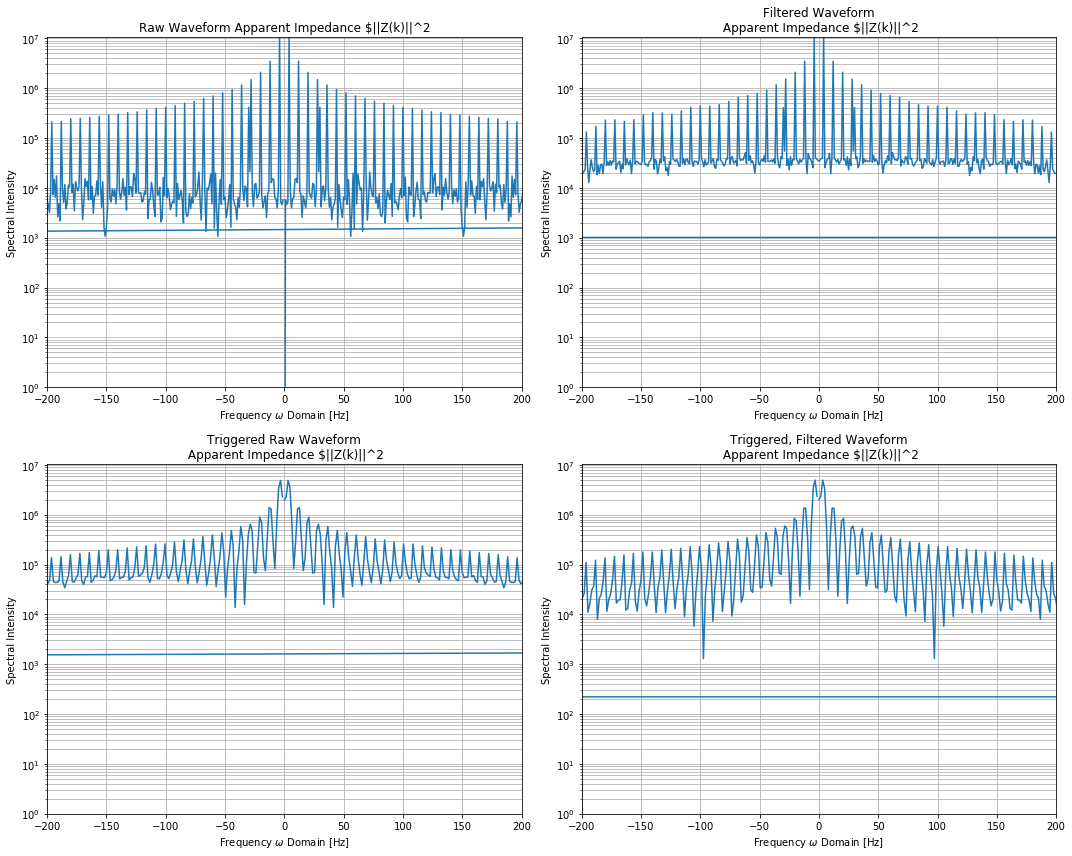

In [545]:
plot_apparent_magnitude(k_domain, k_windowed, raw_zmag, windowed_raw_zmag, filt_raw_zmag, windowed_filt_zmag)

---
## Sets of Two or More Square Waves and Phase Difference Calculations:

In [19]:
# To make things a bit faster, we can define a function to simulate waveforms for the subsequent analyses.
def make_simulated_squares(A, t_offset, phi_offset, dc_offset):
    """
    .. description:: Generates a signal with a period of 1s at a sample rate of 8192 [S/s] 
        with white noise and an additional 60 cps waveform added to make the output somewhat
        more representative of what might be seen in the field. 
    :param amplitude:
    :param time_offset:
    :param phase_offset:
    :param dc_offset:
    :return sig:
    """
    N = 8192  # number of samples
    T = 1 # Sampling period (seconds)
    F_s = 8192  # [Samples/second]
    F_tx = 4.00  # Fundamental frequency of the waveform (Hz)
    tau = np.float(1./F_s)
#     TIME_OFFSET = N/2  # time offset provided for simulation
#     AMP = 2000  # amplitude (in ADC values)
    NOISE_LVL = A / 20  # Naive way to set noise on the signal (not true SNR)
#     DC_OFFSET = 4000  # DC offset in ADC values

    t = np.linspace(0, N-1, N, endpoint=False)
    noise = NOISE_LVL * np.random.normal(0, 1, t.shape)
    pure_sig = A * signal.square(2 * np.pi * F_tx * (t - t_offset) + phi_offset) + NOISE_LVL * np.sin(np.pi* 60 *t) + dc_offset
    sig = pure_sig + noise
    
    return t, sig

In [21]:
# Make a couple of signals with different timing offsets and a constant PHASE OFFSET from
# Signal A (Eventually this can be iterated over to test the results in a unit test framework)
a = 2000
ta_offset = N/2
phia_offset = 0
dca_offset = 4000
b = 3000
tb_offset = N/4
phib_offset = np.pi / 4 # simple pi/4 radians offset. Which is huge for our purposes... 
dcb_offset = 1000

t, st_a = make_simulated_squares(a, ta_offset, phia_offset, dca_offset)
_, st_b = make_simulated_squares(b, ta_offset, phib_offset, dcb_offset)

In [24]:
# Plotting the waveform as a sanity check:
def plot_2waveforms(t, sa, sb, dca_offset, dcb_offset, a, b, ypad=1000):
    domain_size = t.shape[0]
    max_amp = (a if a > b else b)
    max_dc_offset = (dca_offset if dca_offset > dcb_offset else dcb_offset)
    
    plt.plot(t, sa, sb)
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.axis([-100, domain_size-1, -max_dc_offset - max_amp + ypad, max_dc_offset + max_amp + ypad])
    plt.grid(True)
    
    plt.show()

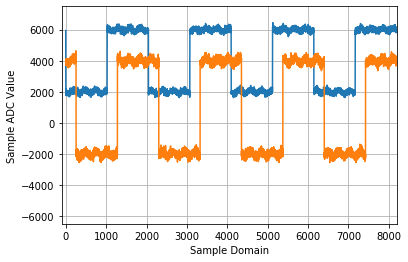

In [25]:
plot_2waveforms(t, st_a, st_b, dca_offset, dcb_offset, a, b, ypad=500)

So far so good.  Now zero the waveforms and apply the filtering and triggering logic.  These should now be built into a function that calls other functions to do the heavy DSP lifting for each. 

In [120]:
def rising_edge_trigger(filt_zeroed_sig, filt_sig_gradient, gradient_max, N):
    """
    """
    positive_trigger_indices = (j for j in range(N - 1) if 
                           ((filt_sig_gradient[j] >= (2/3) * gradient_max) and
                            filt_zeroed_sig[j - 1] < filt_zeroed_sig[j]))
    t0 = next(positive_trigger_indices)
    print(f"First rising trigger found at index {t0}!")
    return t0

In [121]:
def falling_edge_trigger(filt_zeroed_sig, filt_sig_gradient, gradient_max, N):
    """
    """
    negative_trigger_indices = (j for j in range(N-1, 0, -1)  if 
                            ((filt_sig_gradient[j] <= (2/3) * -gradient_max) and
                             filt_zeroed_sig[j + 1] < filt_zeroed_sig[j]))
    tf = next(negative_trigger_indices)
    print(f"Last falling trigger found at index {tf}!")
    return tf

In [122]:
def adjust_trigger_window(t0, tf):
    """
    .. description:: Define the window (change to even number of values if window is odd)
    """
    Nw = np.abs(t0 - tf)
    if Nw % 2 != 0:
        tf = tf - 1
        Nw = np.abs(t0 - tf)
        print("Window altered for even number of samples...")
    
    print(f"(t_0, t_f) = ({t0}, {tf}) with sample size {Nw}")
    # Shift the original signal 
    return t0, tf, Nw

In [123]:
def edge_triggers(s_0, filt_sig_gradient, gradient_max, N):
    """
    """
    t0 = rising_edge_trigger(filt_zeroed_sig, filt_sig_gradient, gradient_max, N)
    tf = falling_edge_trigger(filt_zeroed_sig, filt_sig_gradient, gradient_max, N)
    t0, tf, Nw = adjust_trigger_window(t0, tf)
    
    return t0, tf, Nw

In [124]:
def define_windowed_signal(s_0, N, forder=4, fcut=200):
    """
    .. description:: Filters the original signal, locates rising and falling edge triggers, 
    and then windows the signal and adjusts the timing offsets automatically.
    :param s_0: Original unfiltered signal to apply triggers to
    :param N:
    :param forder:
    :param fcut:
    :return windowed_signal: Windowed original signal
    """
    # Filter the signal
    ang_freq, resp, filt_sig_0 = butterworth_digital_lpf(s_0, forder, fcut, N)
    
    # Compute the 1D gradient of the filtered signal
    filt_sig_gradient = np.gradient(filt_sig_0)
    gradient_max = np.nanmax(filt_sig_gradient)
    
    # Set trigger indices
    t0, tf, Nw = edge_triggers(s_0, filt_sig_gradient, gradient_max, N)

    # Adjust the trigger window to be an even number of samples (simplifies the FFT later on)
#     t0, tf, Nw = adjust_trigger_window(t0, tf)
    
    # Window the signal
    windowed_sig = zeroed_sig[t0:tf]
    
    # Define the new time domain given the window size
    tw = np.linspace(0, Nw-1, Nw, endpoint=False)
    
    return Nw, tw, windowed_sig

In [152]:
# Conditioning function:
def signal_conditioning(t_domain, sig):
    """
    :return win_sig_0: Trigger-windowed ORIGINAL noisy signal (no filters) array with offset removed. 
    """
    N_samples = t_domain.shape[0]
    sig_0 = remove_dc_offset(sig)
    Nw, t_window, win_sig_0 = define_windowed_signal(sig_0, N_samples, forder=4, fcut=200)
    
    return Nw, t_window, win_sig_0

In [156]:
def match_signal_windows(Nwa, st_a_0w, Nwb, st_b_0w):
    """ 
    Align and match the signal windows in start trigger and length by truncating
    the longer of the two signals to match the shorter one.
    """
    Ndiff = np.abs(Nwa - Nwb)
    # Determine which signal is shorter and shift to match in t-domain
    if Nwa <= Nwb:
        Nm = Nwa
        st_a_0wm = st_a_0w
        st_b_0wm = np.roll(st_b_0w, -Ndiff)[0:Nm]
    else:
        Nm = Nwb
        st_b_0wm = st_b_0w
        st_a_0wm = np.roll(st_a_0w, -Ndiff)[0:Nm]
    
    t_m = np.linspace(0, Nm - 1, Nm, endpoint=False)
    
    # Truncate the shorter by applying the mask to both arrays:
#     st_a_0wm = st_a_0w[0:Nm]
#     st_b_0wm = st_b_0w[0:Nm]
    
    if st_a_0wm.shape[0] == st_b_0wm.shape[0]:
        print("Windowed signal arrays have been matched in length")
    else:
        print("Windowed signal array length mismatch... ")

    
    return t_m, st_a_0wm, st_b_0wm

In [160]:
# Use the same filter order and cutoff for both signals and plot the conditioned waveforms 
# with window triggering and offsets corrected. Phase relationship should remain the same. 
Nwa, ta_window, st_a_0w = signal_conditioning(t, st_a)

Waveform Average Value = 4000.236507697657
First rising trigger found at index 1037!
Last falling trigger found at index 6170!
Window altered for even number of samples...
(t_0, t_f) = (1037, 6169) with sample size 5132


In [161]:
Nwb, tb_window, st_b_0w = signal_conditioning(t, st_b)

Waveform Average Value = 1000.0909514149342
First rising trigger found at index 1292!
Last falling trigger found at index 6426!
(t_0, t_f) = (1292, 6426) with sample size 5134


In [162]:
# Naively match the signal window dimensions in order to compare spectral data of the two 
# Numerically 
t_m, st_a_0w, st_b_0w = match_signal_windows(Nwa, st_a_0w, Nwb, st_b_0w)

Windowed signal arrays have been matched in length


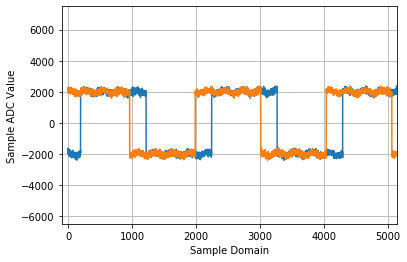

In [163]:
# Sanity check plot.
plot_2waveforms(t_m, st_a_0w, st_b_0w, dca_offset, dcb_offset, a, b, ypad=500)

Success!

## Calculate and Plot Phase Shifts between Sa and Sb

First, functions for the various data manipulations should be defined for more rapid development once the analyses get more complicated.  Seeing as a large number of files containing multiple hundreds of these packets will eventually be processed, getting a highly efficient, parallelized implementation of the DSP processes is critical to developing a useful tool.

In [178]:
### Phase difference calculation
# TODO: Make this into a function
def compute_freq_spectra(s_t, N_samples, tau_rate):
    """
    .. description::
    :param s_t:
    :param N_samples:
    :param tau_rate:
    :return k:
    :return s_k:
    """
    s_k = fft.fft(s_t) 
    k = fft.fftfreq(N_samples, tau_rate)
    return k, s_k

In [355]:
def pairwise_phase_difference_spectrum(sa_k, sb_k):
    """
    Estimate the phase angle of each waveform and the associated shift between them, holding
    S_a(k) as a reference wavform and taking the difference of the derived phase arrays. 
    
    The phase shift corresponds to modulation of the complex part of the transmitted/
    received waveform, which is an indication of either inductive or capacitive frequency-
    dependent responses of the signal due to the electrical network betweewn the electrodes
    formed by the water and target. 
    
    Calculate the phase shift from a reference spectrum (sa_k) and a shifted spectrum (sb_k)
    :param sa_k:
    :param sb_k:
    :return phase_shift_spectrum:
    """
    #Calculate the phase from np.angle but taking every other value (the odd indexed values are zero.)
#     phase_a_k = np.angle(sa_k)[::2]
#     phase_b_k = np.angle(sb_k)[::2]
    phase_a_k = np.angle(sa_k)
    phase_b_k = np.angle(sb_k)
    # Shifting such that the phase of S_a is the reference value, take the difference
    # of the spectra as:
    return phase_b_k - phase_a_k
    

In [416]:
# def pairwise_apparent_impedance_spectrum(sa_k, sb_k):
#     """
#     Use numpy.absolute() library method to obtain the REAL components of each signal. 
#     Take the absolute difference between the real signal components to obtain the apparent
#     impedance magnitude (which corresponds to Marine Resistivity measurements!)
#     """
#     za_k = np.absolute(sa_k)
#     zb_k = np.absolute(sb_k)
# #     return np.abs(zb_k - za_k)
#     return np.abs(zb_k + za_k)

In [ ]:
def apparent_impedance_spectrum(s_k):
    """
    """
    z_k = np.absolute(s_k)
    return z_k

In [417]:
def plot_phase_shift_and_magnitude(k, k_win, delta_phi_ab, delta_phi_w_ab, 
                                   z_mag_ab, z_mag_w_ab):
    
    delta_phi_ab_intensity = np.nanmax(delta_phi_ab)
    delta_phi_w_ab_intensity = np.nanmax(delta_phi_w_ab)
    z_k_intensity = np.nanmax(z_mag_ab)   # Arbitrary spectral intensity 
    z_k_min = np.nanmin(z_mag_ab)
    z_k_w_intensity = np.nanmax(z_mag_w_ab)
    z_k_w_min = np.nanmin(z_mag_w_ab)

    plt.figure(figsize=(15, 15))
    
    # Raw Phase Shift
    plt.subplot(221)
    plt.plot(fft.fftshift(k), fft.fftshift(delta_phi_ab))
    plt.title('Raw Waveform Phase Shift $\Delta\phi(k)$\n\
                (Marine IP Response by Frequency)')
    plt.xlabel('Angular Frequency $\omega$ [rad/s]')
    plt.ylabel('Phase Angle Deflection ${S_a}\angle{S_b}$ [rad]')
    plt.axis([-200, 200, -delta_phi_ab_intensity, delta_phi_ab_intensity])
    plt.grid(True) 
    
    # Raw ||Z||^2
    plt.subplot(222)
    plt.semilogy(fft.fftshift(k), fft.fftshift(z_mag_ab))
    plt.title('Raw Waveform\n Apparent Impedance $||Z(k)||^2$\n\
                (Marine Resistivity Measurement by Frequency)')
    plt.xlabel('Frequency $\omega$ Domain [Hz]')
    plt.ylabel('Spectral Intensity')
    plt.axis([-200, 200, z_k_min, z_k_intensity])
    plt.grid(which='both', axis='both') 
    
    # Windowed Phase Shift
    plt.subplot(223)
    plt.plot(fft.fftshift(k_win), fft.fftshift(delta_phi_w_ab))
    plt.title('Trigger-Windowed Waveform Phase Shift $\Delta\phi_{w}(k)$\n\
                (Marine IP Response by Frequency)')
    plt.xlabel('Angular Frequency $\omega$ [rad/s]')
    plt.ylabel('Phase Angle Deflection ${S_a}\angle{S_b}$ [rad]')
    plt.axis([-200, 200, -delta_phi_w_ab_intensity, delta_phi_w_ab_intensity])
    plt.grid(True) 
    
    # Filtered Windowed ||Z||^2
    plt.subplot(224)
    plt.semilogy(fft.fftshift(k_win), fft.fftshift(z_mag_w_ab))
    plt.title('Trigger-Windowed Waveform\n Apparent Impedance $||Z_{w}(k)||^2$\n\
                (Marine Resistivity Measurement by Frequency)')
    plt.xlabel('Frequency $\omega$ Domain [Hz]')
    plt.ylabel('Spectral Intensity (arb units)')
    # Set the viewing window to -200 to 200 Hz
    plt.axis([-200, 200, z_k_w_min, z_k_w_intensity])
    plt.grid(which='both', axis='both')
    
    plt.tight_layout()
    plt.show()

In [418]:
# Frequency spectrum for original waveforms Sa and Sb
k_domain, s0a_k = compute_freq_spectra(st_a, N, tau) 
_, s0b_k = compute_freq_spectra(st_b, N, tau)

In [419]:
# Frequency spectrum for windowed waveforms Sa and Sb
Nm = t_m.shape[0] # Length of the time domain gives us the number of samples.
k_w_domain, swa_k = compute_freq_spectra(st_a_0w, Nm, tau) 
_, swb_k = compute_freq_spectra(st_b_0w, Nm, tau)

In [420]:
# Compute the marine induced polarization frequency spectrum between signal A and signal B 
# unwindowed
marine_r_k = pairwise_apparent_impedance_spectrum(s0a_k, s0b_k)

In [421]:
# Compute the marine induced polarization frequency spectrum between signal A and signal B 
# unwindowed
marine_ip_k= pairwise_phase_difference_spectrum(s0a_k, s0b_k)

In [422]:
# Compute the marine resistivity apparent impedance frequency (k) spectrum `marine_r_k`
# Windowed
marine_r_k_windowed = pairwise_apparent_impedance_spectrum(swa_k, swb_k)

In [423]:
# Compute the marine resistivity apparent impedance frequency (k) spectrum `marine_r_k`
# Windowed
marine_ip_k_windowed = pairwise_phase_difference_spectrum(swa_k, swb_k)

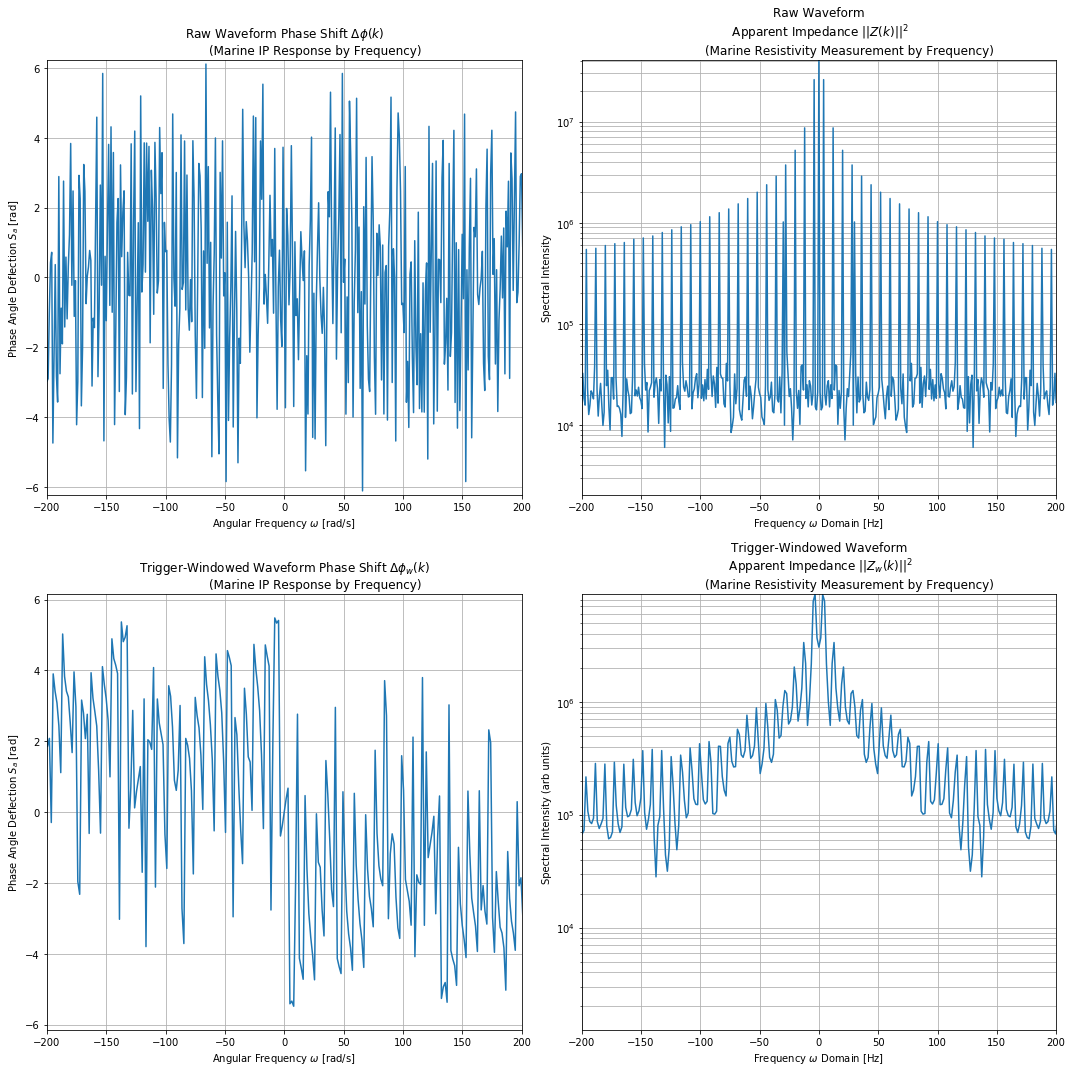

In [424]:
plot_phase_shift_and_magnitude(k_domain, k_w_domain, marine_ip_k,
                               marine_ip_k_windowed, marine_r_k, marine_r_k_windowed)

---
## Set a Baseline with Sba and Sbb:
Mimics baseline measurements in the lab and the field. Every system has some defined phase shifts.  The goal here is to statistically manage and remove the baseline phase shifts to look only for anomalies in the data from a test signal set. 

To account for ambient noise and other system anomalies independent of the presence of target materials in the seawater, the averaging of **frequency domain magnitude and phase responses** for multiple baseline packets to establish an aggregate baseline is the first step. 

#### Setting up the simulated waveforms:
Assuming we have three different channels with different DC offsets and amplitudes corresponding to three different channel-pairs of receiver electrodes, we can generate simulated square waves with variable timing offsets and DC offsets using a quick little loop. From there, we need to build some additional functions for processing multiple waveforms at once. These would be contained in a separate module for handling the track-level data flow.  

Also assuming the data is parsed and parceled out into packets appropriately, and the necessary metadata is also available to the functions, conditioning can occur in parallel. 

In [ ]:
# Make a couple of signals with different timing offsets and a constant PHASE OFFSET from
# Signal A (Eventually this can be iterated over to test the results in a unit test framework)
def make_multichannel_waveforms(m_channels, dphi_offset, dt_offset, dc_offset_range, amp_range)
    a = 2000
    ta_offset = N/2
    phia_offset = 0
    dca_offset = 4000
    b = 3000
    tb_offset = N/4
    phib_offset = np.pi / 4 # simple pi/4 radians offset. Which is huge for our purposes... 
    dcb_offset = 1000

    t, st_a = make_simulated_squares(a, ta_offset, phia_offset, dca_offset)
    _, st_b = make_simulated_squares(b, ta_offset, phib_offset, dcb_offset)

## Remove Baseline and Check for Anomalies:
Goal is to quickly find anomalies and filter out any baseline signals in the phase angle and Marine Resistivity data components from the signals. The most reduced, compressed output format possible is best. 

In [56]:
# Make simulated "baseline" signals and process them with dsp()
def simulate_squares(number_of_channels, dc_offset_max, dc_offset_min,
                              amplitude_max, amplitude_min):
    N = 8192  # number of samples
    T = 1 # Sampling period (seconds)
    F_s = 8192  # [Samples/second]
    tau = np.float(1./F_s)
    t = np.linspace(0, N-1, N, endpoint=False)
    offsets = np.random.randint(60, size=number_of_channels)    
    # define the matrix of signals.
    
    all_channel_wavepacket = np.empty((N, number_of_channels))
    
    for j in range(number_of_channels):
        TIME_OFFSET = N / offsets[j]  # time offset provided for simulation
        AMP = np.random.randint(amplitude_min, amplitude_max)  # amplitude (in ADC values)
        NOISE_LVL = AMP / np.random.randint(10, 40)  # Naive way to set noise on the signal (not true SNR)
        DC_OFFSET = np.random.randint(dc_offset_min, dc_offset_max)  # DC offset in ADC values
        F_tx = 4.00  # Fundamental frequency of the waveform (Hz)
        noise = NOISE_LVL * np.random.normal(0, 1, t.shape)
        pure_sig = AMP * signal.square(2 * np.pi * F_tx * t - TIME_OFFSET) + NOISE_LVL * np.sin(np.pi* 60 *t) + DC_OFFSET
        sig = pure_sig + noise
        all_channel_wavepacket[:, j] = sig
    return t, T, tau, all_channel_wavepacket

In [76]:
# Plotting the waveforms as a sanity check:
def plot_all_waveforms(t, signals):
    domain_size = t.shape[0]
#     max_amp = (a if a > b else b)
#     max_dc_offset = (dca_offset if dca_offset > dcb_offset else dcb_offset)
#     plt.plot(t, sa, sb)
    plt.figure(figsize=(20,20))
    number_of_channels = signals.shape[-1]
    for p in range(number_of_channels):
        plt.plot(t, signals[:, p])
    plt.title(f"Simulation of {number_of_channels} Randomly Generated Square Waves for DSP Analysis")
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
#     plt.axis([-100, domain_size-1, -max_dc_offset - max_amp + ypad, max_dc_offset + max_amp + ypad])
    plt.grid(True)
    plt.show()

In [77]:
n_channels = 6
base_offset_max = 4000
base_offset_min = -4000
base_amp_max = 4000
base_amp_min = 500

t_domain, period, tau, baseline_packets = simulate_squares(n_channels, base_offset_max, base_offset_min,
                                base_amp_max, base_amp_min)

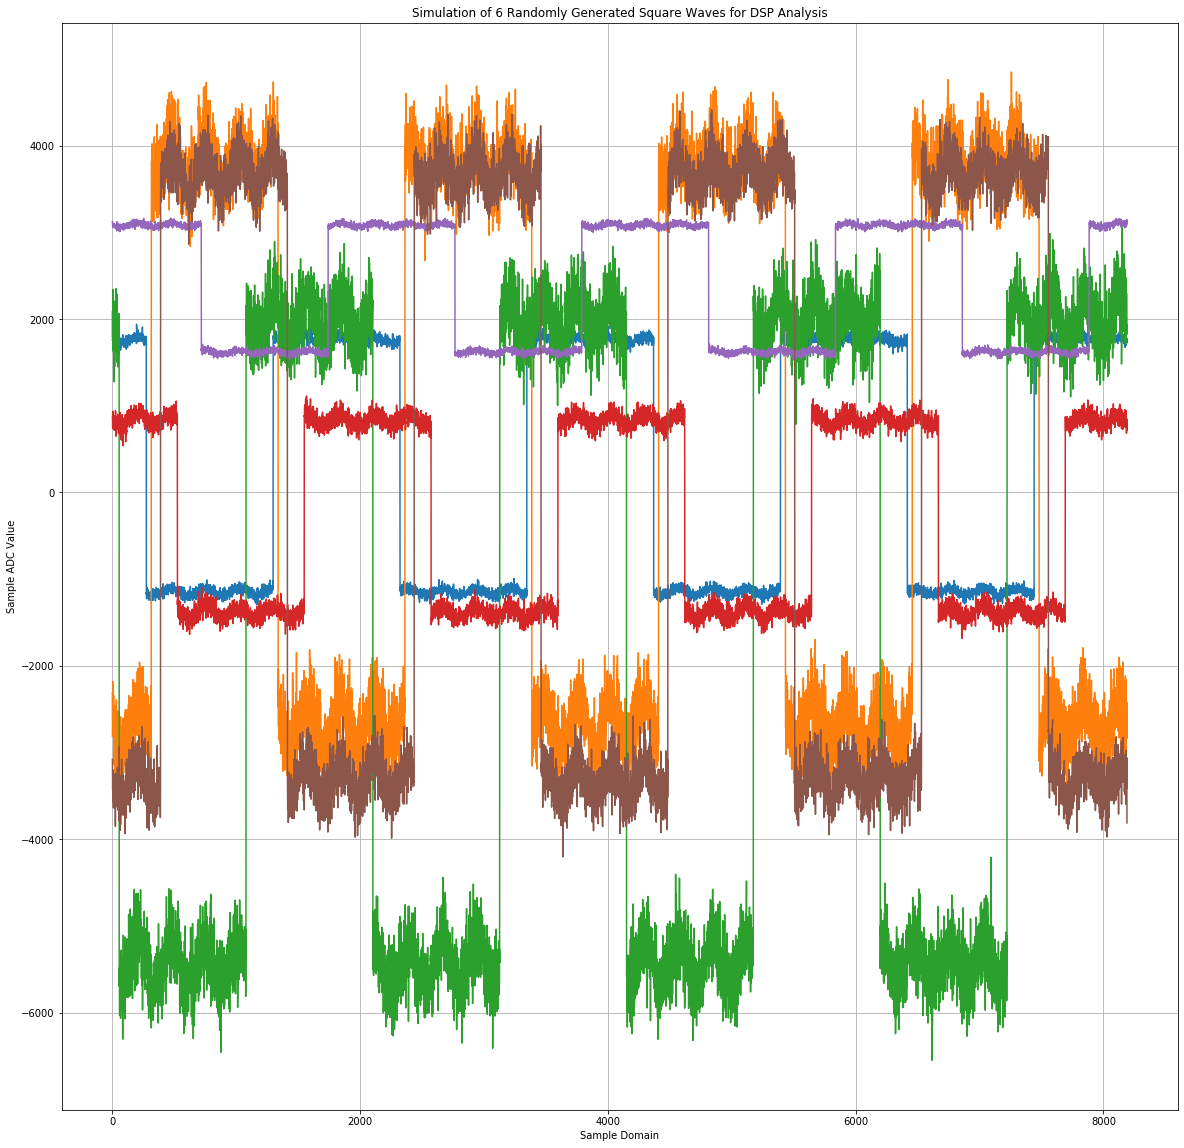

In [78]:
plot_all_waveforms(t_domain, baseline_packets)

In [1]:
# define a DSP signal processing function that calls the other relevant functions. 
def dsp(t, packet, filter=True, filter_cut=200, sample_rate=8192):
    n_w = np.empty((1, number_of_channels))
    n_w[0], tb_window[0], s_t_w[:, 0] = signal_conditioning(t, s_t[:, 0])
    for p in range(1, number_of_channels):
        # remove dc offsets for all signals
        n_w[p], _, s_t_w[:, p] = signal_conditioning(t, s_t[:, p])
        
        # Signal windowing
        min_win = np.min(n_w)
        
        # calculate frequency spectra

        # calculate result spectra
        marine_ip_k= pairwise_phase_difference_spectrum(s0_k[:,0], s_k[:,p])
        marine_r_k = apparent_impedance_spectrum(s_k[:,p])
    
    return marine_ip_k, marine_r_k

In [74]:
# aggregate the baseline signals from the baseline_spectrum_set
def aggregate_baseline_signals(baseline_spectrum_set):
    return baseline_spectrum

In [75]:
# define baseline subtraction function
def subtract_baseline_average(baseline_avg_spectrum, measured_spectrum):
    pass

In [ ]:
# run baseline_subtraction



## Isolate Phase and Magnitude Anomalies Present in Test Packet Group and Baseline Packet Groups:

In [ ]:
# phase anomaly detector function
def phase_anomaly_find(phase_difference_spectrum):
    pass
    

In [ ]:
# impedance anomaly detector function
def impedance_anomaly_find(phase_difference_spectrum):
    pass